In [1]:
import aplpy
import astropy
import matplotlib
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from matplotlib.colors import LogNorm
from astropy.wcs import WCS
from astropy import wcs
import astropy.wcs
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
import numpy as np
from astropy.coordinates import match_coordinates_sky
from astropy.convolution import Gaussian2DKernel
from scipy.signal import convolve as scipy_convolve
from astropy.convolution import convolve,convolve_fft
from astropy.convolution import interpolate_replace_nans
from astropy.nddata.utils import Cutout2D
import matplotlib.pyplot as mpl
from matplotlib import cm
import matplotlib as mp
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors
import astropy.units as u
from spectral_cube import SpectralCube
from matplotlib.colors import LogNorm
from reproject import reproject_interp
import plotly.graph_objects as go
import skimage.measure as measure
import skimage as ski

In [2]:
data = "data/Herschel_column.fits"
hdu      = fits.open(data)[0]
wcs_herschel = WCS(hdu.header)

xray = "data/Xray_Clavel_chandra_pigs-cube_smoothed_4k.fits"
hdu_xray      = fits.open(xray)[0]
wcs_xray = WCS(hdu_xray.header)

x3_filename = "data/Xray_Clavel_chandra_pigs-cube_smoothed_3k.fits"
x3_hdu      = fits.open(x3_filename)[0]
x3_wcs = WCS(x3_hdu.header)

HCNO = "data/CMZ_3mm_HNCO.fits"
hdu_HCNO      = fits.open(HCNO)[0]
wcs_HCNO = WCS(hdu_HCNO.header)

sio = "data/CMZ_3mm_sio.fits"
hdu_sio      = fits.open(sio)[0]
wcs_sio = WCS(hdu_sio.header)

wcs_xray_2axis=wcs_xray.dropaxis(2)
wcs_HCNO_2axis=wcs_HCNO.dropaxis(2)
wcs_sio_2axis=wcs_sio.dropaxis(2)

hdu_cutout             = fits.open('herschel_cutout.fits')[0]
wcs_cutout             = WCS(hdu_cutout.header)
wcs_xray_2axis=wcs_xray.dropaxis(2)

In [3]:
xray_2axis=wcs_xray_2axis.to_header()
hdu_xray_2axis= fits.PrimaryHDU(header=xray_2axis)

# World coordinates of Xray data pixels

In [4]:
fx, fy = wcs_xray_2axis.wcs_pix2world(1., 1., 1)
sx, sy = wcs_xray_2axis.wcs_pix2world(1., 175., 1)
tx, ty = wcs_xray_2axis.wcs_pix2world(313., 1., 1)
bx, by = wcs_xray_2axis.wcs_pix2world(313., 175., 1)

print('Top left pixel: {0} {1}'.format(fx, fy))
print('Bottom left pixel: {0} {1}'.format(sx, sy))
print('Top right pixel: {0} {1}'.format(tx, ty))
print('Bottom right pixel: {0} {1}'.format(bx, by))


Top left pixel: 0.12705561045719718 -0.10088885901891921
Bottom left pixel: 0.12705556164573617 -0.052555542199756985
Top right pixel: 0.04038883349204565 -0.10088885827906537
Bottom right pixel: 0.04038888293333853 -0.052555541814348364


# Cropping Herschel file to match Xray file

In [5]:
herschel_filename = "data/Herschel_column.fits"
hdu_herschel      = fits.open(herschel_filename)[0]
wcs_herschel = WCS(hdu_herschel.header)

In [6]:
wcs_xray_2axis.pixel_to_world(313/2, 175/2)

<SkyCoord (Galactic): (l, b) in deg
    (0.08358333, -0.07658333)>

In [7]:
import os
import aplpy
import numpy as np
from astropy.wcs import WCS
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D

cmzoom          = 'data/Herschel_column.fits'
hdu             = fits.open(cmzoom)[0]
wcs             = WCS(hdu.header)


pos             = wcs.world_to_pixel(SkyCoord('0.08358333deg -0.07658333deg',
                 frame='galactic'))
cutout          = Cutout2D(hdu.data, position=[(pos[0]), (pos[1])],
                  size=(15,27), wcs=wcs)
hdu.data        = cutout.data
hdu.header.update(cutout.wcs.to_header())
hdu.writeto('herschel_cutout.fits', overwrite=True)

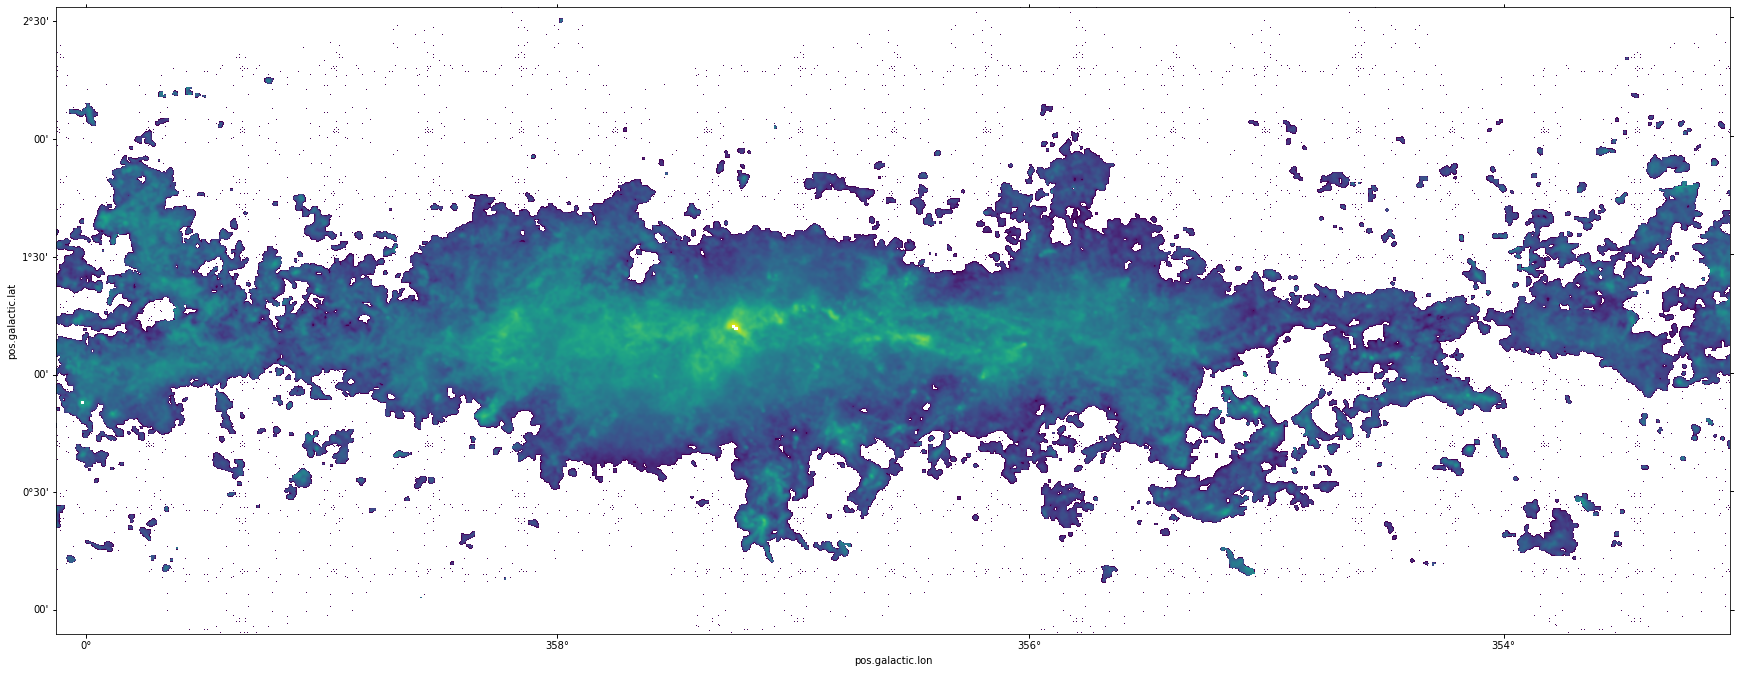

In [8]:
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(111, projection=wcs_cutout)
ax.imshow(hdu_herschel.data, norm='log')


# reproject xray onto herschel

In [9]:
rescaled_xray_data, _ = reproject_interp((hdu_xray.data[11], wcs_xray_2axis), hdu_cutout.header)

rescaled_xray_imagehdu = fits.PrimaryHDU(data = rescaled_xray_data, 
                                             # wrap up our reprojection as a new fits HDU object
                                             header = hdu_cutout.header)

wcs_rescale_xray           = WCS(rescaled_xray_imagehdu.header)

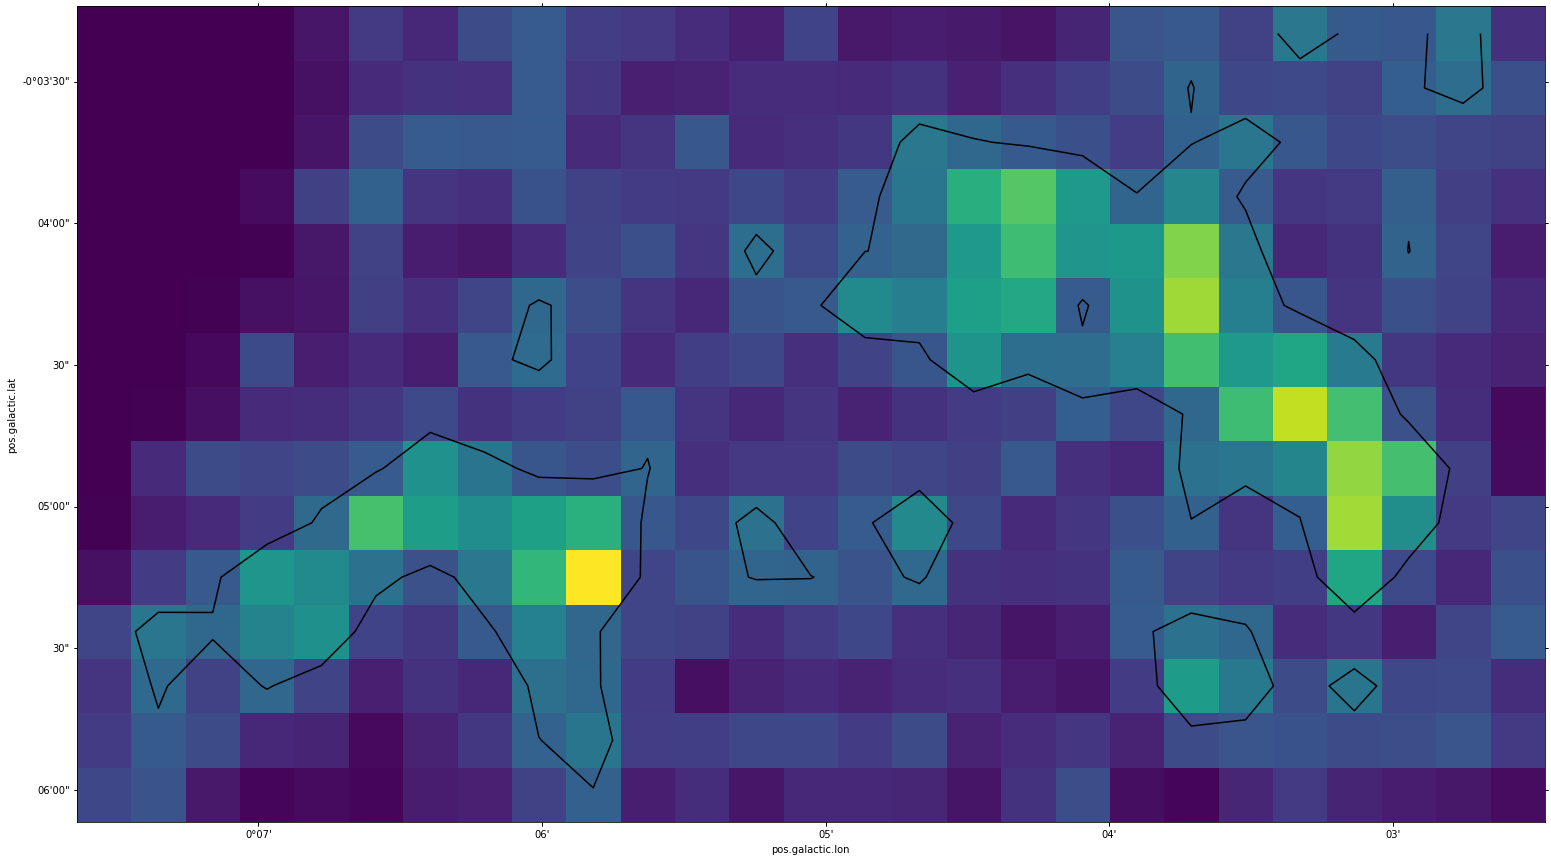

In [10]:
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(111, projection=wcs_rescale_xray)
ax.imshow(rescaled_xray_data)
ax.contour(rescaled_xray_data, colors='black' 
         ,transform=ax.get_transform(wcs_rescale_xray),levels=[2.5e-9])

# Flux Ratio

In [11]:
from mpl_toolkits.axes_grid1 import ImageGrid
import skimage.measure as measure
from skimage.draw import polygon2mask
import skimage

xray_start= 9
partial_flux=[]
rescaled_xray_arr=[]

for year in range(8):
    rescaled_xray_data, _ = reproject_interp((hdu_xray.data[xray_start+year], wcs_xray_2axis), hdu_cutout.header)

    rescaled_xray_imagehdu = fits.PrimaryHDU(data = rescaled_xray_data, 
                                             # wrap up our reprojection as a new fits HDU object
                                             header = hdu_cutout.header)

    wcs_rescale_xray           = WCS(rescaled_xray_imagehdu.header)
    rescaled_xray_arr.append(rescaled_xray_data)
    if year==0:                                             #adding together the intensities from slices 11-16 (2010-2016)
        hdu_arr=rescaled_xray_data
    else:
        hdu_arr=np.add(hdu_arr,rescaled_xray_data)


partial_flux=[]
for year in range(len(rescaled_xray_arr)):
    partial_flux.append(rescaled_xray_arr[year]/hdu_arr)             #calculate percentages for each year

# Multiplying xray flux ratios by herschel column density

In [12]:
xray_start= 9

#multiplying herschel densities by xray flux ratio 
hersc_density=[]
for i in range(8):
    hersc_density.append(hdu_cutout.data*partial_flux[i])

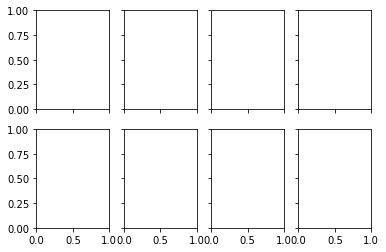

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True)


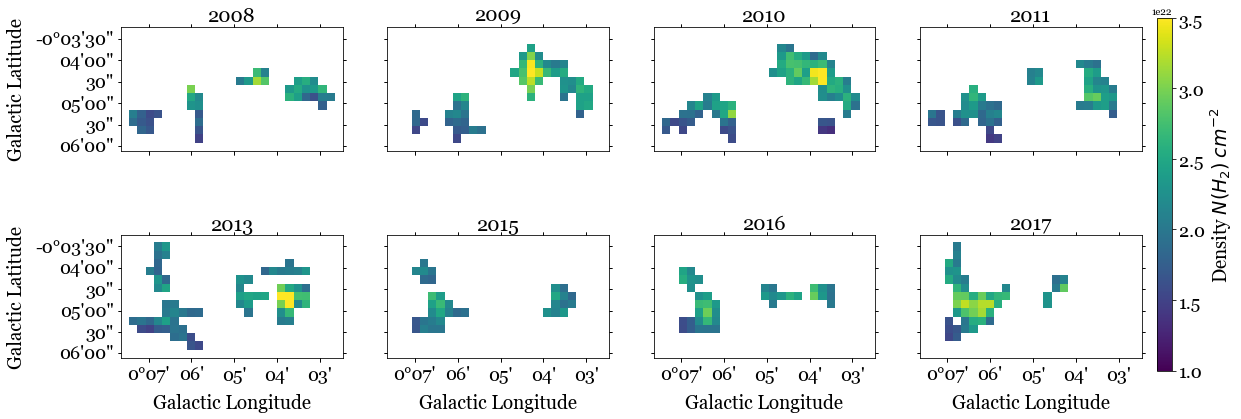

In [14]:
from astropy.visualization.wcsaxes import WCSAxes
import numpy as np
import scipy
from mpl_toolkits.axes_grid1 import ImageGrid
from skimage.draw import polygon2mask
from astropy.visualization.wcsaxes import WCSAxes
import numpy as np
import scipy
from mpl_toolkits.axes_grid1 import ImageGrid


xray_start=9
fig = plt.figure(figsize=(21,7))
years=['2008','2009','2010','2011','2013','2015','2016','2017']
matplotlib.rcParams['font.sans-serif'] = "georgia"   
row=2
col=4

for year in range(8):
    #contours=measure.find_contours(hdu_xray.data[year+xray_start], 2.5e-9)
    contours=measure.find_contours(rescaled_xray_arr[year], 2.5e-9)
    coord=plt.subplot(row,col,year+1 ,projection=wcs_rescale_xray, slices=('x', 'y'))
    lon = coord.coords[0]
    lat = coord.coords[1]

    for j in contours:
        if max(j[:,1])-min(j[:,1])>2 or max(j[:,0])-min(j[:,0])>2:
        #if max(j[:,1])-min(j[:,1])>30:
            mask = ski.draw.polygon2mask(partial_flux[year].shape, j)
            result = np.ma.masked_array(hersc_density[year], np.invert(mask))
            plt.imshow(result,vmin=0,vmax=3.5e22)
        if year<col: #Remove x labels on first row
            lon.set_ticklabel_visible(False)
            lon.set_axislabel('')

        if year%col!=0:
            lat.set_ticklabel_visible(False)
            lat.set_axislabel('')
    lon.set_ticklabel(size=18)
    lat.set_ticklabel(size=18)
    plt.title(years[year], size=20)
    plt.ylabel('Galactic Latitude', size=19)
    plt.xlabel('Galactic Longitude',size=19)
    #plt.xlim(150, 300)
    #plt.ylim(35, 150)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.01, 0.7])

for ax in axes.flat:
    im = ax.imshow(result,vmin=1e22,vmax=3.5e22)
cbar=fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label= r'Density $N(H_2)$ $cm^{-2}$',size=19)
fig.savefig('herschel_ratio_2010_2017.png',bbox_inches='tight')


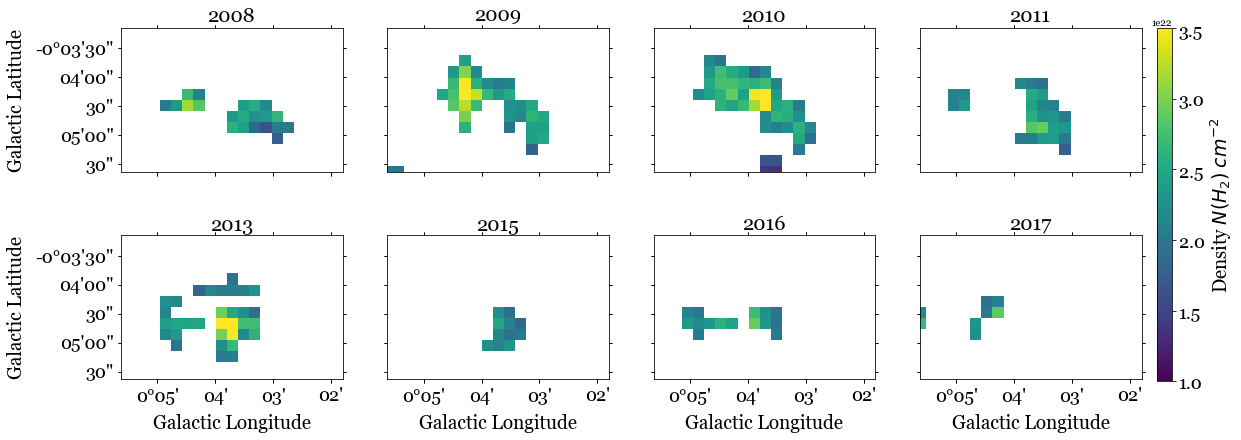

In [15]:
from astropy.visualization.wcsaxes import WCSAxes
import numpy as np
import scipy
from mpl_toolkits.axes_grid1 import ImageGrid
from skimage.draw import polygon2mask
from astropy.visualization.wcsaxes import WCSAxes
import numpy as np
import scipy
from mpl_toolkits.axes_grid1 import ImageGrid


xray_start=9
fig = plt.figure(figsize=(21,7))
years=['2008','2009','2010','2011','2013','2015','2016','2017']
matplotlib.rcParams['font.sans-serif'] = "georgia"   
row=2
col=4

for year in range(8):
    #contours=measure.find_contours(hdu_xray.data[year+xray_start], 2.5e-9)
    contours=measure.find_contours(rescaled_xray_arr[year], 2.5e-9)
    coord=plt.subplot(row,col,year+1 ,projection=wcs_rescale_xray, slices=('x', 'y'))
    lon = coord.coords[0]
    lat = coord.coords[1]

    for j in contours:
        if max(j[:,1])-min(j[:,1])>2 or max(j[:,0])-min(j[:,0])>2:
        #if max(j[:,1])-min(j[:,1])>30:
            mask = ski.draw.polygon2mask(partial_flux[year].shape, j)
            result = np.ma.masked_array(hersc_density[year], np.invert(mask))
            plt.imshow(result,vmin=0,vmax=3.5e22)
        if year<col: #Remove x labels on first row
            lon.set_ticklabel_visible(False)
            lon.set_axislabel('')

        if year%col!=0:
            lat.set_ticklabel_visible(False)
            lat.set_axislabel('')
    lon.set_ticklabel(size=18)
    lat.set_ticklabel(size=18)
    plt.title(years[year], size=20)
    plt.ylabel('Galactic Latitude', size=19)
    plt.xlabel('Galactic Longitude',size=19)
    plt.xlim(10, 30)
    plt.ylim(2, 15)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.01, 0.7])

for ax in axes.flat:
    im = ax.imshow(result,vmin=1e22,vmax=3.5e22)
cbar=fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label= r'Density $N(H_2)$ $cm^{-2}$',size=19)
fig.savefig('stone_herschel_ratio_2008_2017.png',bbox_inches='tight')


# CMZoom

In [16]:
xray = "Xray_Clavel_chandra_pigs_cube_smoothed_4k_updated.fits"
hdu_xray      = fits.open(xray)[0]
wcs_xray = WCS(hdu_xray.header)

xray_3 = "Xray_Clavel_chandra_pigs_cube_smoothed_3k_updated.fits"
hdu_xray_3    = fits.open(xray_3)[0]
wcs_xray_3 = WCS(hdu_xray_3.header)

cmzoom = "data/cmzoom_cutout.fits"
hdu_cmzoom      = fits.open(cmzoom)[0]
wcs_cmzoom = WCS(hdu_cmzoom.header)

wcs_xray_2axis=wcs_xray.dropaxis(2)
wcs_xray_3_2axis=wcs_xray_3.dropaxis(2)

In [17]:
print(contours[3][:, 1])

[15.         14.51298847 14.35515695 15.         15.39272406 15.86489875
 15.        ]


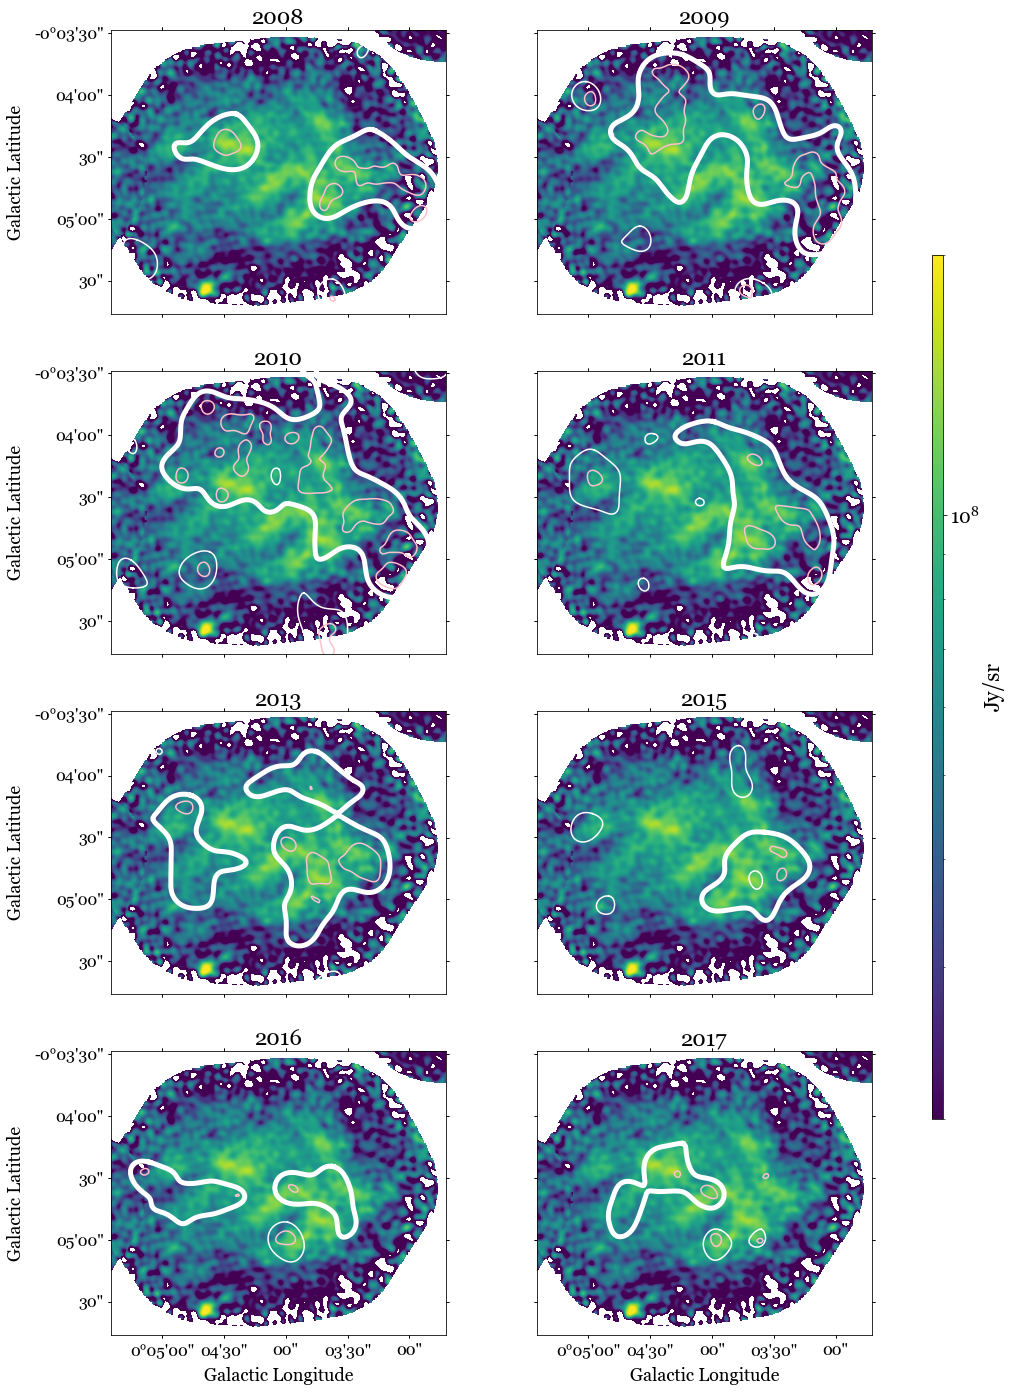

In [18]:
from astropy.visualization.wcsaxes import WCSAxes
import numpy as np
import scipy
from mpl_toolkits.axes_grid1 import ImageGrid

xray_start= 9

#multiplying herschel densities by xray flux ratio 
fig = plt.figure(figsize=(14,24))
years=['2008','2009','2010','2011','2013','2015','2016','2017']
matplotlib.rcParams['font.sans-serif'] = "georgia"   
row=4
col=2

#make vmax lower
#remove white contours
#grayscale?

for year in range(8):
    coord=plt.subplot(row,col, year+1 ,projection=wcs_cmzoom)
    contours=measure.find_contours(hdu_xray.data[year+xray_start], 2.5e-9)
    lon = coord.coords[0]
    lat = coord.coords[1]
    
    im=coord.imshow((hdu_cmzoom.data),norm=LogNorm(vmin=2e7,vmax=2e8))
    coord.contour(x3_hdu.data[xray_start+year], colors='pink', 
           transform=coord.get_transform(wcs_xray_2axis),levels=[6e-9])
    #coord.contour(hdu_cmzoom.data, colors='white' ,transform=coord.get_transform(wcs_cmzoom),levels=[7.5e7])
    #ax.contour(hdu_xray.data[xray_start+year], colors='#CA195C' ,transform=ax.get_transform(wcs_xray_2axis),levels=2.5e-9)
    for j in contours:
        if max(j[:,1])-min(j[:,1])>30:
            coord.plot(j[:, 1], j[:, 0], color='white',transform=coord.get_transform(wcs_xray_2axis),linewidth=5)

        coord.plot(j[:, 1], j[:, 0], color='white',transform=coord.get_transform(wcs_xray_2axis))
    coord.set_xlim(2600, 2925)
    coord.set_ylim(1290, 1565)

    if year>(xray_start-col-2):
        coord.set_xlabel('Galactic Longitude',fontsize=18)
    else:
        lon.set_ticklabel_visible(False)
        lon.set_axislabel('')

    if year%col==0:
        coord.set_ylabel('Galactic Latitude',fontsize=18)
    else:
        lat.set_ticklabel_visible(False)
        lat.set_axislabel('')
    lon.set_ticklabel(size=16)
    lat.set_ticklabel(size=16)

    plt.title(years[year], size=22)
    
cbar_ax = fig.add_axes([0.95, 0.25, 0.01, 0.5])
cbar=fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=19)
cbar.set_label(label='Jy/sr', size=21)

In [19]:
fig.savefig('stone_cmzoom.png',bbox_inches='tight')

TypeError: get_transform() takes 1 positional argument but 2 were given

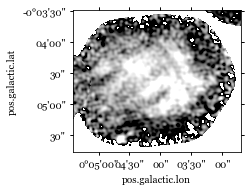

In [20]:

fig = plt.figure(figsize=(22,12))
coord=plt.subplot(row,col, year+1 ,projection=wcs_cmzoom)
coord.imshow((hdu_cmzoom.data),norm=LogNorm(vmin=2e7,vmax=1e8),cmap='gray')
lon = coord.coords[0]
lat = coord.coords[1]
coord.set_xlim(2600, 2925)
coord.set_ylim(1290, 1565)

for j in contours:
    if max(j[:,1])-min(j[:,1])>30:
        coord.plot(j[:, 1], j[:, 0], color='cyan',transform=ax.get_transform(wcs_xray_2axis),linewidth=5)

cbar_ax = fig.add_axes([0.95, 0.25, 0.01, 0.5])
cbar=fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=19)
cbar.set_label(label='Jy/sr', size=21)

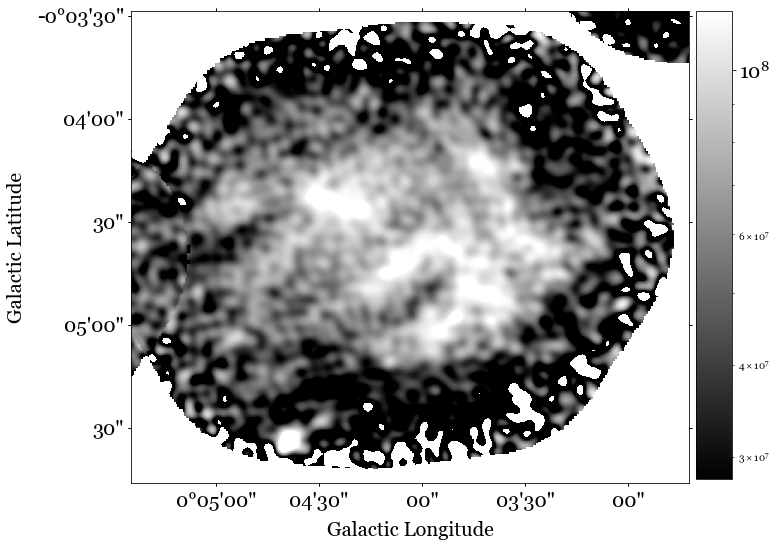

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=wcs_cmzoom)
lon = ax.coords[0]
lat = ax.coords[1]
im=ax.imshow(hdu_cmzoom.data,norm=LogNorm(vmin=2.8e7,vmax=1.2e8),cmap='gray')
#ax.set_xlim(2600, 2925)
plt.xlim(2600, 2925)
plt.ylim(1290, 1565)
#ax.set_ylim(1290, 1565)
#ax.set_ylabel('Galactic Latitude', size=20)
#ax.set_xlabel('Galactic Longitude', size=20)
plt.ylabel('Galactic Latitude', size=20)
plt.xlabel('Galactic Longitude', size=20)
lon.set_ticklabel(size=20)
lat.set_ticklabel(size=20)

cbar_ax = fig.add_axes([0.91, 0.18, 0.05, 0.65])
#fig.colorbar(im, orientation='vertical',pad=0.01,aspect=0.7,shrink=0.5)
cbar=fig.colorbar(im, cax=cbar_ax,aspect=10)
cbar.ax.tick_params(labelsize=20)
#cbar.set_label(label=r" stuff", size=25)

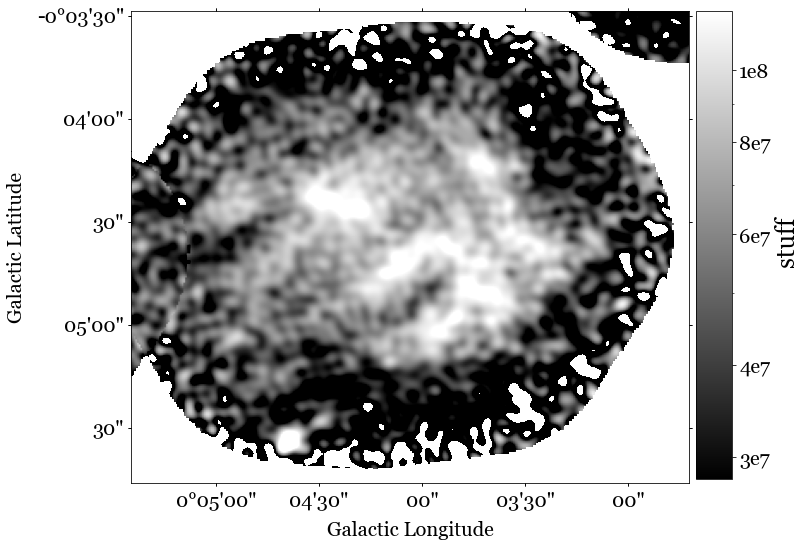

In [ ]:
import matplotlib.pyplot as plt
from astropy.visualization import wcsaxes
from matplotlib.colors import LogNorm
from matplotlib import ticker

# Your existing code
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=wcs_cmzoom)
lon = ax.coords[0]
lat = ax.coords[1]
im = ax.imshow(hdu_cmzoom.data, norm=LogNorm(vmin=2.8e7, vmax=1.2e8), cmap='gray')
plt.xlim(2600, 2925)
plt.ylim(1290, 1565)
plt.ylabel('Galactic Latitude', size=20)
plt.xlabel('Galactic Longitude', size=20)
lon.set_ticklabel(size=20)
lat.set_ticklabel(size=20)

# Manually setting colorbar ticks
cbar_ax = fig.add_axes([0.91, 0.18, 0.05, 0.65])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=20)

# Define the tick positions and labels
ticks = [3e7, 4e7, 6e7, 8e7, 1.0e8]
tick_labels = ['3e7', '4e7', '6e7', '8e7', '1e8']

# Set the tick positions and labels
cbar.set_ticks(ticks)
cbar.ax.set_yticklabels(tick_labels)
cbar.set_label(label=r" stuff", size=25)
plt.show()


In [ ]:
fig.savefig('cmzoom_hersch.pdf',bbox_inches='tight')

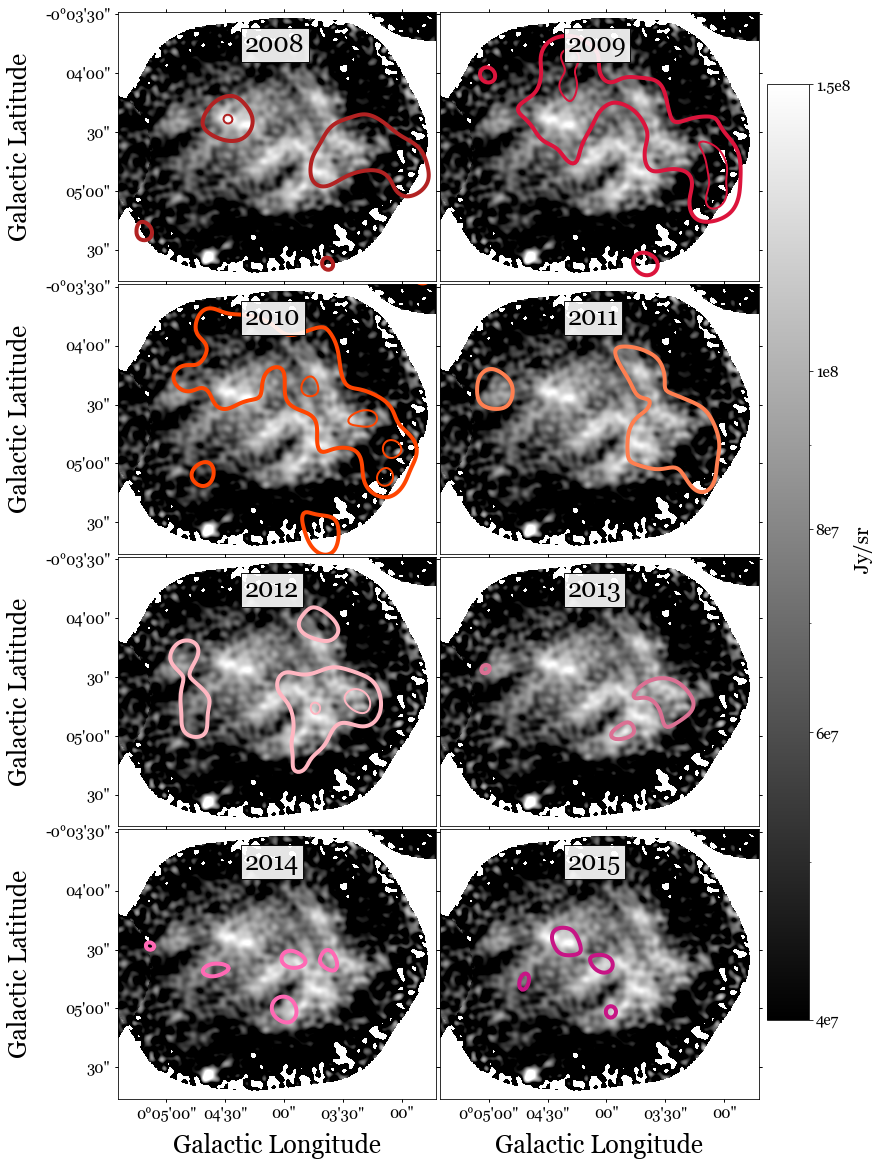

In [ ]:
from astropy.visualization.wcsaxes import WCSAxes
import numpy as np
import scipy
from mpl_toolkits.axes_grid1 import ImageGrid
xray_start=9
fig = plt.figure(figsize=(11.5,20))
fig.subplots_adjust(wspace=0.01, hspace=0.01)
years=['2008','2009','2010','2011','2013','2015','2016','2017']
matplotlib.rcParams['font.sans-serif'] = "georgia"   
row=4
col=2
color=['firebrick', 'crimson', 'orangered', 'coral', 'lightpink', 'palevioletred', 'hotpink', 'mediumvioletred']

for year in range(8):
    coord=plt.subplot(row,col, year+1 ,projection=wcs_cmzoom)
    lon = coord.coords[0]
    lat = coord.coords[1]
    plt.xlim(2600, 2925)
    plt.ylim(1290, 1565)
    im=plt.imshow((hdu_cmzoom.data),norm=LogNorm(vmin=4e7,vmax=1.5e8),cmap='gray')
    #coord.contour(hdu_cmzoom.data, colors='white' ,transform=coord.get_transform(wcs_cmzoom),levels=[7.5e7])
    coord.contour(hdu_xray.data[xray_start+year], colors=color[year], linewidths=4,transform=coord.get_transform(wcs_xray_2axis),levels=[3e-9])
    coord.contour(hdu_xray_3.data[xray_start+year], colors=color[year], linewidths=2,transform=coord.get_transform(wcs_xray_3_2axis),levels=[7e-9])
    coord.text(0.40, 0.85, str(round(1999+xray_start+year, 1)), fontsize=25, bbox=dict(facecolor='white', alpha=0.9),transform=coord.transAxes,color="black")# bbox=dict(facecolor='white', alpha=0.9)
    

    if ((row*col)-year)<=col:
        coord.set_xlabel('Galactic Longitude',fontsize=25)
    elif year==5:
        lon.set_ticklabel_visible(False)
        lon.set_axislabel('')
    else:
        lon.set_ticklabel_visible(False)
        lon.set_axislabel('')

    if year%col==0:
        coord.set_ylabel('Galactic Latitude',fontsize=25)
    else:
        lat.set_ticklabel_visible(False)
        lat.set_axislabel('')
    lon.set_ticklabel(size=15)
    lat.set_ticklabel(size=15)

# Manually setting colorbar ticks
cbar_ax = fig.add_axes([0.91, 0.18, 0.05, 0.65])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=15)

# Define the tick positions and labels
ticks = [np.log10(4e7), np.log(6e7), np.log(8e7, 1.0e8,1.5e8)]
tick_labels = ['4e7', '6e7', '8e7', '1e8','1.5e8']

# Set the tick positions and labels
cbar.set_ticks(ticks)
cbar.ax.set_yticklabels(tick_labels)
cbar.set_label(label=r" Jy/sr", size=20)
plt.show()


In [ ]:
fig.savefig('cmzoom_stone.png',bbox_inches='tight')

# cmzoom sticks cloud

In [22]:
stone_cmzoom = "data/G0.068-0.075.H2CO.218.2GHz.fits"
hdu_stone_cmzoom     = fits.open(stone_cmzoom)
wcs_stone_cmzoom = SpectralCube.read(hdu_stone_cmzoom)
hdu_stone_cmzoom.close()

sticks_cmzoom = "data/G0.106-0.082.H2CO.218.2GHz.fits"
hdu_sticks_cmzoom      = fits.open(sticks_cmzoom)
wcs_sticks_cmzoom =SpectralCube.read(hdu_sticks_cmzoom)
hdu_sticks_cmzoom.close()


stone_hdu      = fits.open(stone_cmzoom)[0]
stone_wcs = WCS(stone_hdu.header)
wcs_stone_2axis=stone_wcs.dropaxis(2)

sticks_hdu      = fits.open(sticks_cmzoom)[0]
sticks_wcs = WCS(sticks_hdu.header)
wcs_sticks_2axis=sticks_wcs.dropaxis(2)

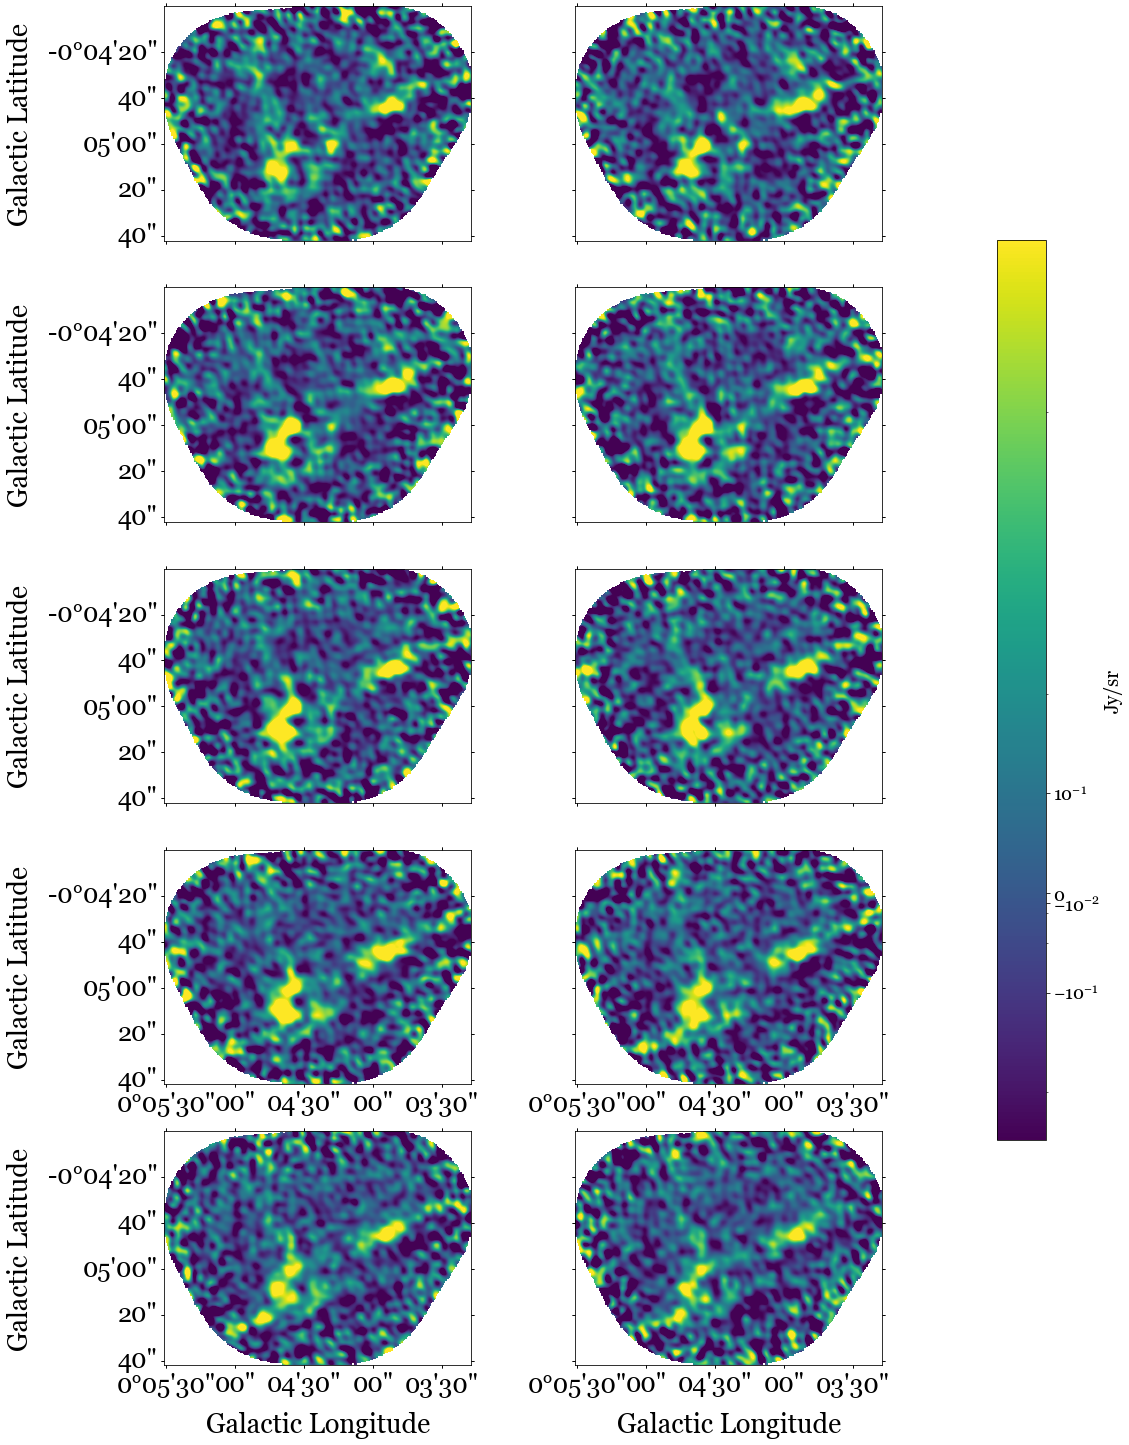

In [ ]:
fig = plt.figure(figsize=(13.5,25))
year=2008
row=5
col=2
r=xray_start-1
years=['2008','2009','2010','2011','2013','2015','2016','2017']
matplotlib.rcParams['font.sans-serif'] = "georgia" 

for i in range(10):
    image = wcs_sticks_cmzoom.unmasked_data[130+i]
    ax = plt.subplot(row, col, i+1, projection=wcs_stone_2axis, slices=('x', 'y'))
    lon = ax.coords[0]
    lat = ax.coords[1]
    #ax.contour(cube[184+i, :, :], colors='cyan', levels=[0.17, 0.3, 0.6, 0.9, 1.2, 1.5])
    
    #ax.contour(x4_hdu.data[xray_start+i], colors='white', 
           #transform=ax.get_transform(wcs_4xray_2axis),levels=[2.5e-9])

    im=ax.imshow(image,norm='asinh',vmin=-.25,vmax=0.7)
    ax.tick_params(labelsize=15)
    #ax.set_ylim(64, 79)
    #ax.text(0.63, 0.07, str(round(cube_vel_kms[i],1))+ ' km/s', fontsize=26, bbox = dict(facecolor = 'white', alpha = 0.9), transform=ax.transAxes)

    if i>(r-col-1):
        ax.set_xlabel('Galactic Longitude',fontsize=27)
    else:
        lon.set_ticklabel_visible(False)
        lon.set_axislabel('')

    if i%col==0:
        ax.set_ylabel('Galactic Latitude',fontsize=27)
    else:
        lat.set_ticklabel_visible(False)
        lat.set_axislabel('')
    lon.set_ticklabel(size=25)
    lat.set_ticklabel(size=25)

cbar_ax = fig.add_axes([1.0, 0.25, 0.05, 0.5])
cbar=fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label='Jy/sr',size=19)
    

# cmzoom stone cloud

UnitConversionError: '' (dimensionless) and 'Jy / beam' are not convertible

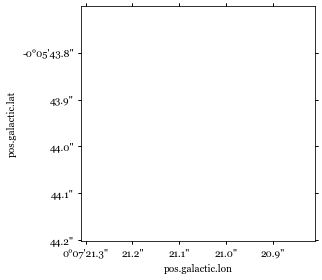

In [ ]:
fig = plt.figure(figsize=(13.5,25))
year=2008
row=5
col=2
r=xray_start-1
years=['2008','2009','2010','2011','2013','2015','2016','2017']
matplotlib.rcParams['font.sans-serif'] = "georgia" 

for i in range(10):
    image = wcs_stone_cmzoom.unmasked_data[130+i]
    ax = plt.subplot(row, col, i+1, projection=wcs_sticks_2axis, slices=('x', 'y'))
    lon = ax.coords[0]
    lat = ax.coords[1]
    #ax.contour(cube[184+i, :, :], colors='cyan', levels=[0.17, 0.3, 0.6, 0.9, 1.2, 1.5])
    
    #ax.contour(x4_hdu.data[xray_start+i], colors='white', 
           #transform=ax.get_transform(wcs_4xray_2axis),levels=[2.5e-9])

    im=ax.imshow(image,norm=LogNorm(vmin=0,vmax=10))
    ax.tick_params(labelsize=15)
    #ax.set_ylim(64, 79)
    #ax.text(0.63, 0.07, str(round(cube_vel_kms[i],1))+ ' km/s', fontsize=26, bbox = dict(facecolor = 'white', alpha = 0.9), transform=ax.transAxes)

    if i>(r-col-1):
        ax.set_xlabel('Galactic Longitude',fontsize=27)
    else:
        lon.set_ticklabel_visible(False)
        lon.set_axislabel('')

    if i%col==0:
        ax.set_ylabel('Galactic Latitude',fontsize=27)
    else:
        lat.set_ticklabel_visible(False)
        lat.set_axislabel('')
    lon.set_ticklabel(size=25)
    lat.set_ticklabel(size=25)

cbar_ax = fig.add_axes([1.0, 0.25, 0.05, 0.5])
cbar=fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label='Jy/sr',size=19)

In [40]:
hdu_stone_cmzoom[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  328                                                  
NAXIS2  =                  260                                                  
NAXIS3  =                  370                                                  
BMAJ    = 0.001022106665919748                                                  
BMIN    = 0.000920510219509741                                                  
BPA     =    28.41383422533909                                                  
BTYPE   = 'Intensity'                                                           
OBJECT  = 'G0.068-0'                                                            
BUNIT   = 'Jy/beam '           /Brightness (pixel) unit                         
TELESCOP= 'SMA     '        

[83.34395248054253, 82.22697167412767, 81.10999086771281, 79.99301006129795, 78.8760292548831, 77.75904844846823, 76.64206764205338, 75.52508683563852, 74.40810602922366, 73.2911252228088, 72.17414441639394, 71.05716360997909, 69.94018280356423, 68.82320199714937, 67.70622119073451, 66.58924038431965, 65.4722595779048, 64.35527877148994, 63.23829796507508, 62.12131715866022, 61.00433635224536, 59.8873555458305, 58.770374739415644, 57.653393933000785, 56.53641312658593, 55.41943232017107, 54.30245151375621, 53.18547070734135, 52.068489900926494, 50.951509094511636, 49.83452828809678, 48.71754748168192, 47.60056667526706, 46.4835858688522, 45.366605062437344, 44.249624256022486, 43.13264344960763, 42.01566264319277, 40.89868183677791, 39.78170103036305, 38.664720223948194, 37.547739417533336, 36.43075861111848, 35.31377780470362, 34.19679699828876, 33.0798161918739, 31.962835385459044, 30.845854579044186, 29.728873772629328, 28.61189296621447]


/Users/danyaalboslani/opt/anaconda3/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:234: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = super().contour(*args, **kwargs)
/var/folders/8n/_rhj_p6j11j3hj9wn3tzy0280000gn/T/ipykernel_48438/4190927876.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.05, w_pad=0.05, h_pad=0.05)


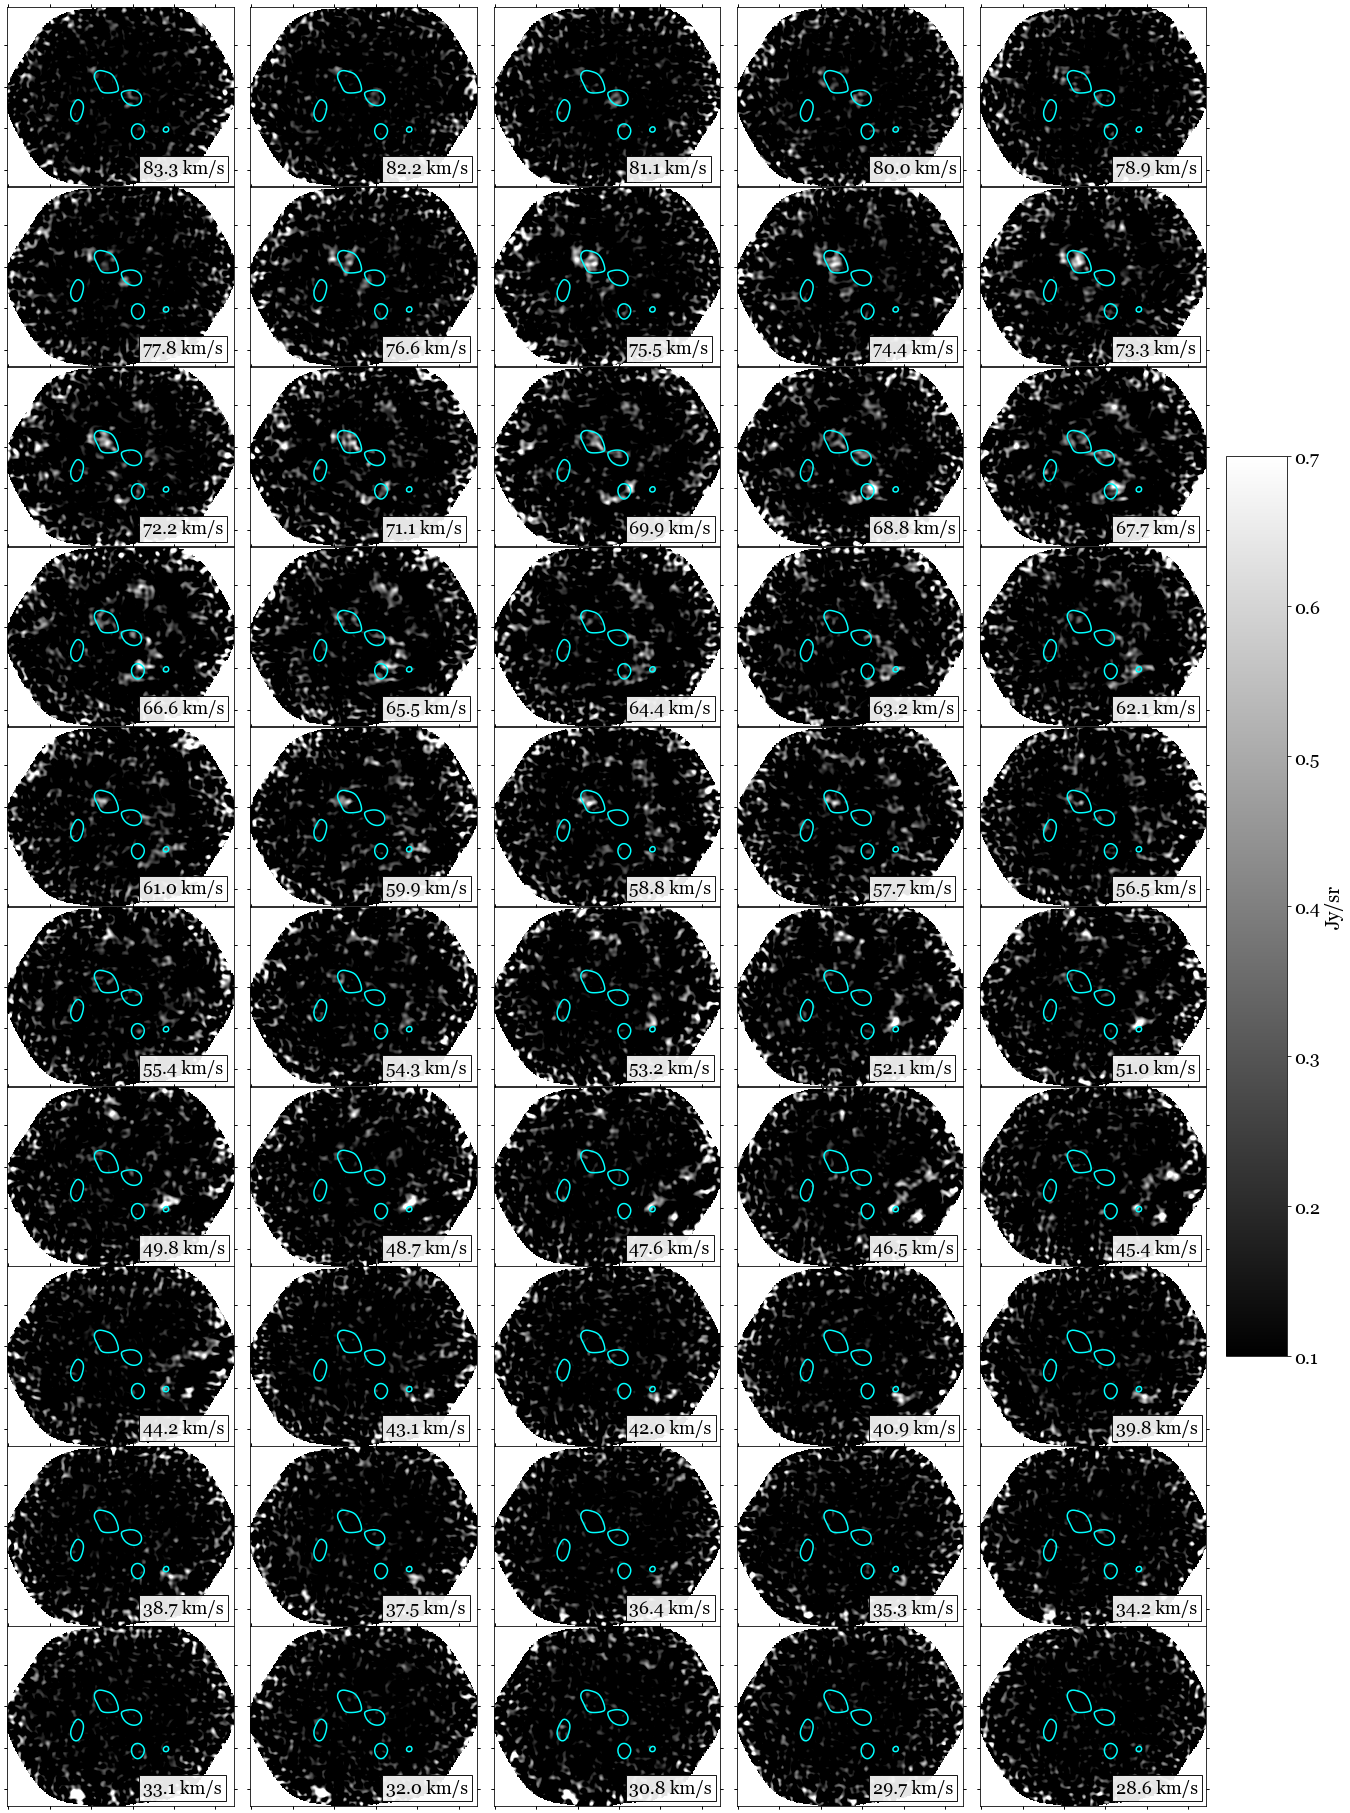

In [66]:
fig = plt.figure(figsize=(17,25))
year=2015
xray_start=year-1999
row=10
col=5
r=xray_start-2
years=['2008','2009','2010','2011','2013','2015','2016','2017']
matplotlib.rcParams['font.sans-serif'] = "georgia" 
x4_filename = "data/Xray_Clavel_chandra_pigs-cube_smoothed_4k.fits"
x4_hdu      = fits.open(x4_filename)[0]
x4_wcs = WCS(x4_hdu.header)
wcs_4xray_2axis=x4_wcs.dropaxis(2)

hdr = hdu_stone_cmzoom[0].header
vel_zero = (float(hdr['CRVAL3'])) #in km/s
del_vel = (float(hdr['CDELT3'])) #in km/s
cube_vel_kms = []
for i in range(row*col):
    cube_vel_kms.append((vel_zero + ((110+i)*del_vel)))
    
print(cube_vel_kms)

for i in range(row*col):
    image = wcs_stone_cmzoom.unmasked_data[120+i]
    ax = plt.subplot(row, col, i+1, projection=wcs_stone_2axis, slices=('x', 'y'))
    lon = ax.coords[0]
    lat = ax.coords[1]
    #ax.contour(cube[184+i, :, :], colors='cyan', levels=[0.17, 0.3, 0.6, 0.9, 1.2, 1.5])
    ax.contour(x4_hdu.data[xray_start], colors='cyan', linewidth=5,
           transform=ax.get_transform(wcs_4xray_2axis),levels=[3e-9])

    im=ax.imshow(image,vmin=0.1, vmax=.7, cmap='gray')
    ax.tick_params(labelsize=15)
    #ax.set_ylim(64, 79)
    ax.text(0.60, 0.07, str(round(cube_vel_kms[i],1))+ ' km/s', fontsize=18, bbox = dict(facecolor = 'white', alpha = 0.9), transform=ax.transAxes)
    lat.set_ticklabel_visible(False)
    lat.set_axislabel('')
    lon.set_ticklabel_visible(False)
    lon.set_axislabel('')


    if i>(r-col-1):
        ax.set_xlabel('Galactic Longitude',fontsize=27)
    else:
        lon.set_ticklabel_visible(False)
        lon.set_axislabel('')

    if i%col==0:
        ax.set_ylabel('Galactic Latitude',fontsize=27)
    else:
        lat.set_ticklabel_visible(False)
        lat.set_axislabel('')
    lon.set_ticklabel(size=25)
    lat.set_ticklabel(size=25)

cbar_ax = fig.add_axes([1.0, 0.25, 0.05, 0.5])
cbar=fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label='Jy/sr',size=19)

plt.tight_layout(pad=0.05, w_pad=0.05, h_pad=0.05)

In [67]:
fig.savefig("xray2017_h2co218.2.pdf", dpi=300, bbox_inches="tight")

/Users/danyaalboslani/opt/anaconda3/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:234: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = super().contour(*args, **kwargs)


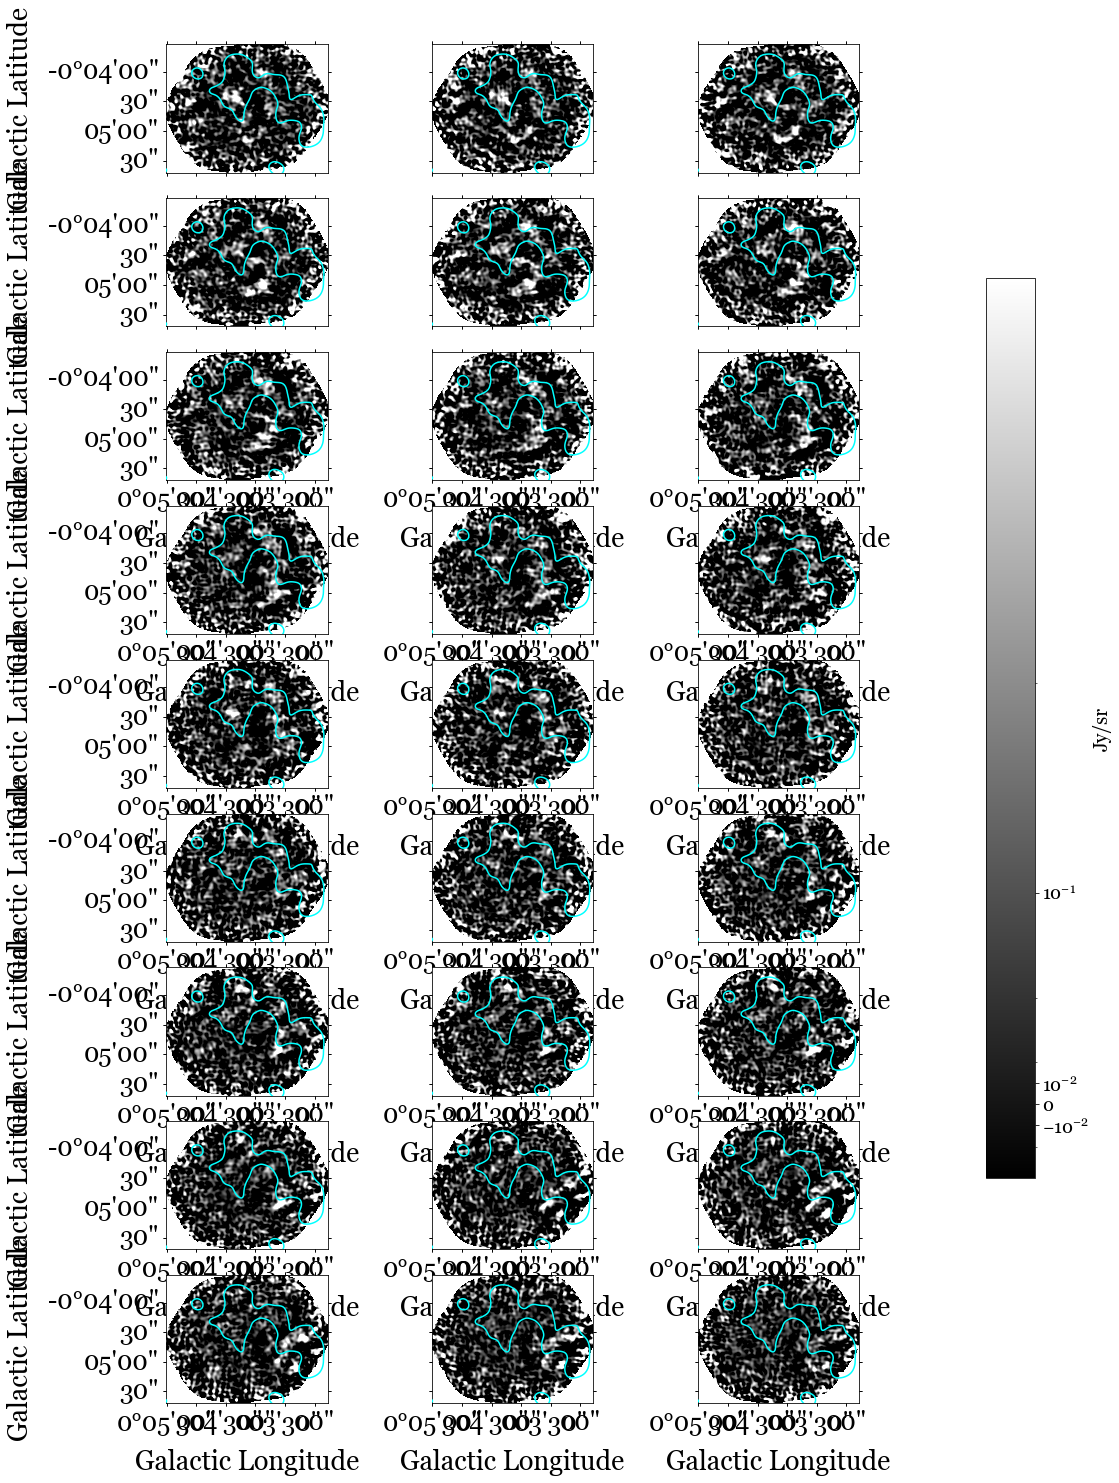

In [27]:
fig = plt.figure(figsize=(13.5,25))
year=2010
xray_start=2009-1999
row=9
col=3
r=xray_start-1
years=['2008','2009','2010','2011','2013','2015','2016','2017']
matplotlib.rcParams['font.sans-serif'] = "georgia" 
x4_filename = "data/Xray_Clavel_chandra_pigs-cube_smoothed_4k.fits"
x4_hdu      = fits.open(x4_filename)[0]
x4_wcs = WCS(x4_hdu.header)
wcs_4xray_2axis=x4_wcs.dropaxis(2)

for i in range(row*col):
    image = wcs_stone_cmzoom.unmasked_data[130+i]
    ax = plt.subplot(row, col, i+1, projection=wcs_stone_2axis, slices=('x', 'y'))
    lon = ax.coords[0]
    lat = ax.coords[1]
    #ax.contour(cube[184+i, :, :], colors='cyan', levels=[0.17, 0.3, 0.6, 0.9, 1.2, 1.5])
    ax.contour(x4_hdu.data[xray_start], colors='cyan', linewidth=5,
           transform=ax.get_transform(wcs_4xray_2axis),levels=[3e-9])

    im=ax.imshow(image,norm='asinh',vmin=-0.035,vmax=0.4,cmap='gray')
    ax.tick_params(labelsize=15)
    #ax.set_ylim(64, 79)
    #ax.text(0.63, 0.07, str(round(cube_vel_kms[i],1))+ ' km/s', fontsize=26, bbox = dict(facecolor = 'white', alpha = 0.9), transform=ax.transAxes)

    if i>(r-col-1):
        ax.set_xlabel('Galactic Longitude',fontsize=27)
    else:
        lon.set_ticklabel_visible(False)
        lon.set_axislabel('')

    if i%col==0:
        ax.set_ylabel('Galactic Latitude',fontsize=27)
    else:
        lat.set_ticklabel_visible(False)
        lat.set_axislabel('')
    lon.set_ticklabel(size=25)
    lat.set_ticklabel(size=25)

cbar_ax = fig.add_axes([1.0, 0.25, 0.05, 0.5])
cbar=fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label='Jy/sr',size=19)